In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing import image
from keras import models, layers 
from keras import callbacks
from keras.applications import Xception
import cv2
import time
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
print(os.getcwd())

C:\


In [0]:
os.chdir(r'E:/2019-3rd-ml-month-with-kakr')

In [4]:
os.listdir()

['car_clf.h5',
 'class.csv',
 'sample_submission.csv',
 'test.csv',
 'test.zip',
 'train',
 'train.csv',
 'train.zip',
 'train_chop',
 'xception_model.png']

In [0]:
train_df = pd.read_csv('train.csv')
train_df['class'] = train_df['class'].astype(str)

In [6]:
train_df.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [0]:
y = train_df['class']
x = train_df.drop('class', axis = 1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1228, stratify = y)

In [0]:
train_set = pd.concat([X_train, y_train], axis = 1)

In [10]:
train_set.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
8706,train_08707.jpg,8,42,493,256,90
3986,train_03987.jpg,45,89,610,426,148
7423,train_07424.jpg,90,177,659,425,35
7413,train_07414.jpg,17,33,389,281,88
625,train_00626.jpg,45,83,590,452,65


In [11]:
train_df.iloc[[8706,3986, 7423], :]

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
8706,train_08707.jpg,8,42,493,256,90
3986,train_03987.jpg,45,89,610,426,148
7423,train_07424.jpg,90,177,659,425,35


In [0]:
validation_set = pd.concat([X_test, y_test], axis=1)

In [13]:
validation_set.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
8243,train_08244.jpg,38,154,474,301,161
8955,train_08956.jpg,5,82,440,277,124
4320,train_04321.jpg,85,98,569,309,168
9247,train_09248.jpg,9,26,639,452,74
9140,train_09141.jpg,59,164,716,419,140


In [14]:
print(train_df.shape)

print(train_set.shape)
print(validation_set.shape)

(10016, 6)
(8012, 6)
(2004, 6)


In [0]:
img=cv2.imread(f'train/{train_df.iloc[0,0]}')

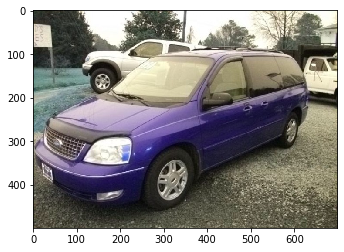

In [0]:
plt.imshow(img)

In [0]:
img_test = cv2.imread(f'train/{train_df.iloc[0, 0]}')  
crop_img_test = img_test[train_df.iloc[0, 2] : train_df.iloc[0, 4] , train_df.iloc[0,1] : train_df.iloc[0, 4]] 


In [0]:
crop_img_test

In [0]:
np.max([train_df.iloc[0,1]-15, 0])

0

In [0]:
def chop_img(data_type, path_df, margin = 15):
  """
     ex) chip_img('trian', train_df, margin = 20)
     
     data_type = train or test as string         
     path_df = train_df or test_df,
     marging = how many pixel left over 
     
     this function create directory as data_type_chop """   
  for i in range(len(path_df.img_file)):
    img = cv2.imread(f'train/{path_df.iloc[i, 0]}')               # load image
    cv2.waitKey(0)
    
    crop_img = img[np.max([path_df.iloc[i, 2] - margin, 0]) : (path_df.iloc[i, 4] + margin), #  y : y + w
                   np.max([path_df.iloc[i,1]-margin, 0]) : (path_df.iloc[i, 3]+margin)]      #  x : x + w   

    cv2.imwrite(f'train_chop/{path_df.iloc[i,0]}', crop_img)  # save the image
    
    cv2.waitKey(0)

In [0]:
chop_img('train', train_df, margin = 20)

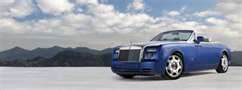

In [0]:
image.load_img(f"train/train_06744.jpg")

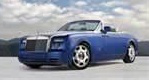

In [0]:
image.load_img(f"train_chop/train_06744.jpg")

In [0]:
train_gen = image.ImageDataGenerator(rescale = 1./255, rotation_range = 40, 
                                     width_shift_range = 0.3, 
                                     height_shift_range=0.3, 
                                     shear_range = 0.3, 
                                     zoom_range = 0.3, 
                                     horizontal_flip = True,
                                     vertical_flip = True                                   
                                    )

validation_gen = image.ImageDataGenerator(rescale = 1./255)

In [16]:
train_data = train_gen.flow_from_dataframe(train_set, 'train_chop', x_col = "img_file", y_col = "class", target_size=(150,150), class_mode='categorical',batch_size=32)

valid_data = validation_gen.flow_from_dataframe(validation_set, 'train_chop', x_col = "img_file", y_col = "class", target_size=(150,150), class_mode='categorical', batch_size=32)

Found 8012 validated image filenames belonging to 196 classes.
Found 2004 validated image filenames belonging to 196 classes.


In [0]:
xception_model = Xception(include_top = False, 
                          input_shape = (150, 150, 3))

In [0]:
plot_model(xception_model, 'xception_model.png')
model_plotting = plt.imread('xception_model.png')

In [25]:
model_ex = models.Sequential()
model_ex.add(xception_model)
model_ex.add(layers.AvgPool2D(2,2, name = 'Avg_pool'))
model_ex.add(layers.Flatten(name = 'Flat'))
model_ex.add(layers.Dense(2048, activation = 'relu', name = 'Dense_1'))
model_ex.add(layers.Dense(196, activation = 'softmax', name = 'Dense_out'))

model_ex.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
Avg_pool (AveragePooling2D)  (None, 2, 2, 2048)        0         
_________________________________________________________________
Flat (Flatten)               (None, 8192)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
Dense_out (Dense)            (None, 196)               401604    
Total params: 38,042,348
Trainable params: 37,987,820
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
model_ex.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [0]:
check_points = callbacks.ModelCheckpoint('car_clf.h5', monitor = 'val_loss', save_best_only=True)

In [28]:
exception_net_history = model_ex.fit_generator(train_data, steps_per_epoch= 8013//32, epochs = 100, validation_data=valid_data, validation_steps=2003//32, callbacks=[check_points])

Epoch 1/100
250/250 [==============================] - 84s 338ms/step - loss: 5.3129 - acc: 0.0055 - val_loss: 5.2770 - val_acc: 0.0086
Epoch 2/100
250/250 [==============================] - 72s 287ms/step - loss: 5.2779 - acc: 0.0084 - val_loss: 5.2760 - val_acc: 0.0086
Epoch 3/100
250/250 [==============================] - 72s 287ms/step - loss: 5.2770 - acc: 0.0084 - val_loss: 5.2750 - val_acc: 0.0081
Epoch 4/100
250/250 [==============================] - 72s 287ms/step - loss: 5.2764 - acc: 0.0084 - val_loss: 5.2742 - val_acc: 0.0081
Epoch 5/100
250/250 [==============================] - 72s 287ms/step - loss: 5.2759 - acc: 0.0084 - val_loss: 5.2736 - val_acc: 0.0091
Epoch 6/100
250/250 [==============================] - 72s 286ms/step - loss: 5.2755 - acc: 0.0083 - val_loss: 5.2733 - val_acc: 0.0071
Epoch 7/100
250/250 [==============================] - 72s 288ms/step - loss: 5.2750 - acc: 0.0083 - val_loss: 5.2720 - val_acc: 0.0101
Epoch 8/100
250/250 [===========================

KeyboardInterrupt: ignored